# Obtaining a training dataset

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

from modules import stats
from modules import regridding

In [62]:
client = Client(n_workers=8, threads_per_worker=1, memory_limit='12GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 89.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37595,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 89.41 GiB
Comm: tcp://127.0.0.1:38407,Total threads: 1
Dashboard: http://127.0.0.1:46453/status,Memory: 11.18 GiB
Nanny: tcp://127.0.0.1:41235,


## Temporal autocorrelation

In [3]:
data = xr.open_mfdataset('../data/control/1024_192/*.nc')
data = data.isel(t=(data.t <= 300)).drop_duplicates('t')

In [ ]:
max_lag = 10.
lag_step = 0.2
u_corr = stats.autocorrelation(data.u, 't', max_lag, lag_step).compute()
w_corr = stats.autocorrelation(data.w, 't', max_lag, lag_step).compute()
theta_corr = stats.autocorrelation(data.theta, 't', max_lag, lag_step).compute()

In [18]:
autocorrelation = xr.merge([u_corr, w_corr, theta_corr])
autocorrelation.attrs['Start time'] = '0'
autocorrelation.attrs['End time'] = '300'
autocorrelation.to_netcdf('../data/control/1024_192/autocorrelation.nc')

[Text(0.5, 0, 'Lag'), Text(0, 0.5, 'Spatially averaged autocorrelation')]

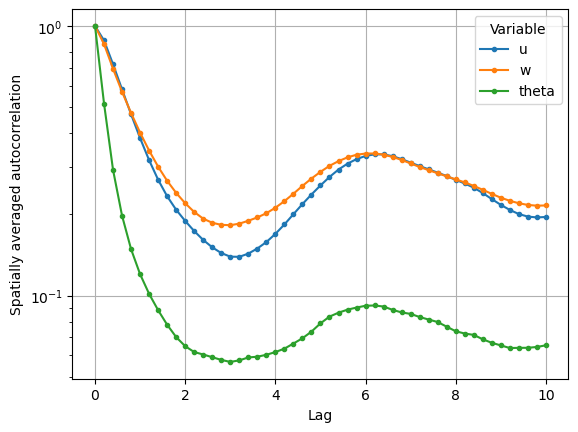

In [14]:
fig, ax = plt.subplots()
for array, label in zip([u_corr, w_corr, theta_corr], ['u', 'w', 'theta']):
    ax.semilogy(array.t_lag, array.mean('x').integrate('z'), label=label, marker='.')

ax.legend(title='Variable')
ax.grid()
ax.set(xlabel='Lag', ylabel='Spatially averaged autocorrelation')

## Subgrid tendencies

1. Run model at 1024 x 192 resolution, saving a pair of states separated by one time step every 3 time units
2. Coarse-grain the first state in each pair and advance it by one time step using the 256 x 192 model

In [44]:
fine_t = xr.open_mfdataset('../data/training/1024x192_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/1024x192_tplusdt/*.nc')
coarse_t = xr.open_mfdataset('../data/training/256x192_from_1024x192_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/256x192_from_1024x192_tplusdt/*.nc')

In [92]:
def tendency(state_t, state_tplusdt):
    tend = (state_tplusdt.drop('t') - state_t.drop('t'))/state_t.timestep
    return tend.assign_coords({'t': state_t.t})

regridder = regridding.Regridder(
    fine_t, coarse_t, dims=['z', 'x'], limits={'z': (0, 1), 'x': (0, 8)})

fine_tend = tendency(fine_t, fine_tplusdt)
coarse_tend = tendency(coarse_t, coarse_tplusdt)
subgrid_tend = regridder(fine_tend.compute()) - coarse_tend.compute()

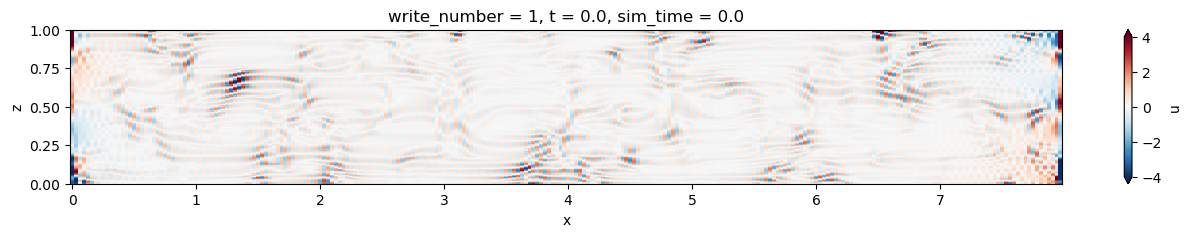

In [94]:
subgrid_tend.u.isel(t=0).plot(figsize=(16,2), vmin=-4, vmax=4, cmap='RdBu_r')